In [1]:
from itertools import product
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.utils.data as utils
from matplotlib import image as img
from matplotlib import pyplot as plt
import os
import pandas as pd

In [12]:
def train(net, X, y, optimizer, criterion, batch_size, lr, p=15):
    X = torch.Tensor(X).float()
    N = len(X)
    y = torch.Tensor(y).long()
    train_size = int(0.75 * N)
    valid_size = N - train_size
    train_index, valid_index = torch.utils.data.random_split(
        np.arange(N), [train_size, valid_size]
    )
    train_dataset = utils.TensorDataset(X[train_index], y[train_index])
    valid_dataset = utils.TensorDataset(X[valid_index], y[valid_index])
    dataloader = utils.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    validloader = utils.DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    j = 0
    epoch = 0
    train_accs = []
    valid_accs = []
    train_losses = []
    valid_losses = []
    best_vloss = float("inf")
    while j < p:
        epoch += 1
        net.train_mode()
        for batch in dataloader:
            optimizer.zero_grad()
            X, y = batch
            X = X.view(-1, 3, 64, 64)
            y = y.view(-1)
            X = X.cuda()
            y = y.cuda()

            loss = criterion(net.forward(X), y)
            loss.backward()
            optimizer.step()

        net.eval_mode()
        train_loss, train_acc = net.evaluate(dataloader, criterion)
        valid_loss, valid_acc = net.evaluate(validloader, criterion)

        train_accs.append(train_acc)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        if valid_loss < best_vloss:
            best_vacc = valid_acc
            best_vloss = valid_loss
            best_net = net.state_dict()
            best_epoch = epoch
            j = 0
        else:
            j += 1

        print("epoch: {}".format(epoch))
        print(" [LOSS] TRAIN {} / VALID {}".format(train_loss, valid_loss))
        print(" [ACC] TRAIN {} / VALID {}".format(train_acc, valid_acc))
    best_model = {
        "net": best_net,
        "best_epoch": best_epoch,
        "final_epoch": epoch,
        "batch_size": batch_size,
        "lr": lr,
        "vacc": best_vacc,
        "vloss": valid_losses,
        "taccs": train_accs,
        "tloss": train_losses,
        "vaccs": valid_accs,
        "convs": net.conv_size,
        "lins": net.lin_size,
    }
    return best_model


def accuracy(y_pred, target):
    correct = torch.eq(y_pred.max(1)[1], target).sum().type(torch.FloatTensor)
    return correct / len(target)


class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x


class Dropout(nn.Module):
    def __init__(self, p=0.3):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        data = x.data
        shape = data.shape
        size = int(shape[0] * shape[1])
        drop_idx = np.random.choice(
            np.arange(size), replace=False, size=int(size * self.p)
        )
        data = data.flatten()
        data[drop_idx] = 0
        data = data.reshape(shape)
        x.data = data
        return x


class Net(nn.Module):
    def __init__(self, input_size, conv_size, lin_size):
        super(Net, self).__init__()

        self.drop = True
        self.lin_size = lin_size
        self.conv_size = conv_size
        self.model = nn.Sequential(
            nn.Conv2d(input_size, conv_size, 3, 1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(True),
            nn.Conv2d(conv_size, conv_size * 2, 3, 1),
            nn.ReLU(True),
            nn.Conv2d(conv_size * 2, conv_size * 2, 3, 1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.ReLU(True),
            Flatten(),
            nn.Linear(conv_size * c, lin_size)).cuda()
        self.dropout = nn.Sequential(Dropout()).cuda()
        self.lin = nn.Sequential(
            nn.ReLU(True),
            nn.Linear(lin_size, 2),
        ).cuda()

    def eval_mode(self):
        self.drop = False
        
    def train_mode(self):
        self.drop = True
        
    def forward(self, x):
        dat = self.model(x)
        if self.drop:
            dat = self.dropout(dat)
        return self.lin(dat)

    def evaluate(self, dataloader, criterion):
        self.eval_mode()
        LOSSES = 0
        ACCURACY = 0
        COUNTER = 0
        for batch in dataloader:
            X, y = batch
            X = X.view(-1, 3, 64, 64)
            y = y.view(-1)
            X = X.cuda()
            y = y.cuda()

            loss = criterion(self.forward(X), y)
            acc = accuracy(self.forward(X), y)
            n = y.size(0)
            LOSSES += loss.sum().data.cpu().numpy() * n
            ACCURACY += acc.sum().data.cpu().numpy() * n
            COUNTER += n

        floss = LOSSES / float(COUNTER)
        faccuracy = ACCURACY / float(COUNTER)
        return floss, faccuracy
    
    def train(self, X, y, epochs, optimizer, criterion, batch_size, lr):
        train_dataset = utils.TensorDataset(X, y)
        dataloader = utils.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
        )
        train_accs = []
        train_losses = []
        for e in epochs:
            net.train_mode()
            for batch in dataloader:
                optimizer.zero_grad()
                X, y = batch
                X = X.view(-1, 3, 64, 64)
                y = y.view(-1)
                X = X.cuda()
                y = y.cuda()

                loss = criterion(net.forward(X), y)
                loss.backward()
                optimizer.step()

            net.eval_mode()
            train_loss, train_acc = net.evaluate(dataloader, criterion)

            train_accs.append(train_acc)
            train_losses.append(train_loss)

            print("epoch: {}".format(epoch))
            print("TRAIN : [LOSS] {} / [ACC] {}".format(train_loss, train_acc))
        print('Training Done')


def create_dataset(cats_path, dogs_path, test_path):
    train_set = []
    target = []
    n_cats = len(os.listdir(cats_path))
    for i in range(1, n_cats):
        f = '{}.Cat.jpg'.format(i)
        mat = img.imread(cats_path + f)
        if not len(mat.shape) == 3:
            mat = np.array((mat, mat, mat)).T
        train_set.append(mat)
        target.append(0)

    n_dogs = len(os.listdir(dogs_path))
    for i in range(1, n_dogs):
        f = '{}.Dog.jpg'.format(i)
        mat = img.imread(dogs_path + f)
        if not len(mat.shape) == 3:
            mat = np.array((mat, mat, mat)).T
        train_set.append(mat)
        target.append(1)

    train_set = np.asarray(train_set)
    target = np.asarray(target)
    
    test_set = []
    n_test = len(os.listdir(test_path))
    for i in range(1, n_test):
        f = '{}.jpg'.format(i)
        mat = img.imread(test_path + f)
        if not len(mat.shape) == 3:
            mat = np.array((mat, mat, mat)).T
        test_set.append(mat)

    return train_set, target, np.asarray(test_set)

In [3]:
test_path = "/home/arthur/git/IFT6135_assignment_1/testset/test/"
dogs_path = "/home/arthur/git/IFT6135_assignment_1/trainset/Dog/"
cats_path = "/home/arthur/git/IFT6135_assignment_1/trainset/Cat/"
X, y, submission = create_dataset(cats_path, dogs_path, test_path)
X = X / 255.0
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

In [13]:
net = Net(3, 32, 512)
par = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("The network contains {} parameters.".format(par))

The network contains 5595650 parameters.


In [14]:
batch_size = 128
learning_rates = [0.01, 0.005, 0.0001, 0.0005]

criterion = nn.CrossEntropyLoss()
for learning_rate in learning_rates:
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    
    result = train(net, X, y, optimizer, criterion, batch_size, learning_rate, p=10)
    net.load_state_dict(result['net'])
    batch_size = int(batch_size / 2)

/home/arthur/.pyvenvs/dl/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch: 1
 [LOSS] TRAIN 0.6931386268193733 / VALID 0.692957033870649
 [ACC] TRAIN 0.4970994199237212 / VALID 0.5087017403838395
epoch: 2
 [LOSS] TRAIN 0.6930453750366543 / VALID 0.692917516491942
 [ACC] TRAIN 0.4970994199197467 / VALID 0.5087017403719163
epoch: 3
 [LOSS] TRAIN 0.6929682319606393 / VALID 0.6928720754441035
 [ACC] TRAIN 0.4982996599339736 / VALID 0.5103020604478523
epoch: 4
 [LOSS] TRAIN 0.6928884523736959 / VALID 0.6928316338178181
 [ACC] TRAIN 0.518837100771369 / VALID 0.5241048209880395
epoch: 5
 [LOSS] TRAIN 0.6928081063101226 / VALID 0.6927900491392261
 [ACC] TRAIN 0.5386410615734635 / VALID 0.5303060612301275
epoch: 6
 [LOSS] TRAIN 0.6927210046401332 / VALID 0.6927263292104489
 [ACC] TRAIN 0.5431753017369482 / VALID 0.5351070214102425
epoch: 7
 [LOSS] TRAIN 0.6926284312343426 / VALID 0.6926230535098948
 [ACC] TRAIN 0.5409081816422889 / VALID 0.529705941200161
epoch: 8
 [LOSS] TRAIN 0.6925239136650331 / VALID 0.6925749614801996
 [ACC] TRAIN 0.5457091418343273 / VALID

epoch: 65
 [LOSS] TRAIN 0.7156753383923143 / VALID 0.724514210956243
 [ACC] TRAIN 0.5247049410040954 / VALID 0.5143028605899994
epoch: 66
 [LOSS] TRAIN 0.6600625494158077 / VALID 0.6614678785738456
 [ACC] TRAIN 0.6059878642454762 / VALID 0.6155231046447708
epoch: 67
 [LOSS] TRAIN 0.6959555253844552 / VALID 0.7036387982500103
 [ACC] TRAIN 0.5428419017275866 / VALID 0.5347069413942394
epoch: 68
 [LOSS] TRAIN 0.6660009475718374 / VALID 0.6704191187902269
 [ACC] TRAIN 0.6001200240405709 / VALID 0.5959191838606139
epoch: 69
 [LOSS] TRAIN 0.6791228990900745 / VALID 0.6777121138753928
 [ACC] TRAIN 0.5809828632750844 / VALID 0.5851170234106426
epoch: 70
 [LOSS] TRAIN 0.7100402218719845 / VALID 0.706374103115854
 [ACC] TRAIN 0.5497099420023082 / VALID 0.5487097419662746
epoch: 71
 [LOSS] TRAIN 0.7215785157833925 / VALID 0.7180272821641774
 [ACC] TRAIN 0.5405747816468379 / VALID 0.5439087817623129
epoch: 72
 [LOSS] TRAIN 0.674729501397449 / VALID 0.6732770921135216
 [ACC] TRAIN 0.587184103489351

epoch: 1
 [LOSS] TRAIN 0.632631807825824 / VALID 0.6394755091278952
 [ACC] TRAIN 0.6496632660223006 / VALID 0.6411282256689756
epoch: 2
 [LOSS] TRAIN 0.6324060099986726 / VALID 0.6382257925627064
 [ACC] TRAIN 0.6477962259237724 / VALID 0.6437287457551115
epoch: 3
 [LOSS] TRAIN 0.635878269876044 / VALID 0.6409968827385548
 [ACC] TRAIN 0.6450623458263405 / VALID 0.6393278656088845
epoch: 4
 [LOSS] TRAIN 0.6344070392043827 / VALID 0.6402497906927157
 [ACC] TRAIN 0.6473294659329231 / VALID 0.6355271054449309
epoch: 5
 [LOSS] TRAIN 0.6310936995225723 / VALID 0.6394919471088278
 [ACC] TRAIN 0.648663065986267 / VALID 0.6395279055811163
epoch: 6
 [LOSS] TRAIN 0.6316419199616812 / VALID 0.6379885891600355
 [ACC] TRAIN 0.6515303061009566 / VALID 0.6413282656769772
epoch: 7
 [LOSS] TRAIN 0.6332817981582869 / VALID 0.6419424284909052
 [ACC] TRAIN 0.6476628659383101 / VALID 0.6419283856890587
epoch: 8
 [LOSS] TRAIN 0.6503792327070519 / VALID 0.6607494798629946
 [ACC] TRAIN 0.6270587451101709 / VALI

epoch: 24
 [LOSS] TRAIN 0.6094680307880754 / VALID 0.6104360182157967
 [ACC] TRAIN 0.6784023471678894 / VALID 0.6777355471153835
epoch: 25
 [LOSS] TRAIN 0.6094332443695669 / VALID 0.6104317365896466
 [ACC] TRAIN 0.6782023071479645 / VALID 0.6785357071771982
epoch: 26
 [LOSS] TRAIN 0.6096662732333415 / VALID 0.6106934188890276
 [ACC] TRAIN 0.6781356271492717 / VALID 0.6783356671572733
epoch: 27
 [LOSS] TRAIN 0.6093374491532803 / VALID 0.6104444761971612
 [ACC] TRAIN 0.6778689071346284 / VALID 0.6769353871012621
epoch: 28
 [LOSS] TRAIN 0.6098686516098144 / VALID 0.6109997959560479
 [ACC] TRAIN 0.6769353871131855 / VALID 0.677335467105342
epoch: 29
 [LOSS] TRAIN 0.6093143391165644 / VALID 0.6105744949482184
 [ACC] TRAIN 0.6783356671612477 / VALID 0.677335467105342
epoch: 30
 [LOSS] TRAIN 0.609048181945915 / VALID 0.6103780903823854
 [ACC] TRAIN 0.6782689871387083 / VALID 0.6789357871812781
epoch: 31
 [LOSS] TRAIN 0.6091880838402177 / VALID 0.6105260215036439
 [ACC] TRAIN 0.678202307151939

epoch: 88
 [LOSS] TRAIN 0.605809970033831 / VALID 0.6093506089244564
 [ACC] TRAIN 0.6813362672812717 / VALID 0.6805361072333675
epoch: 89
 [LOSS] TRAIN 0.6066638560559644 / VALID 0.6102108442800048
 [ACC] TRAIN 0.681736347297275 / VALID 0.6787357471732766
epoch: 90
 [LOSS] TRAIN 0.6058565377115989 / VALID 0.6093405857697132
 [ACC] TRAIN 0.6814029472799645 / VALID 0.6797359472013612
epoch: 91
 [LOSS] TRAIN 0.6056590261495598 / VALID 0.6091948102345155
 [ACC] TRAIN 0.6818030272999421 / VALID 0.680536107227406
epoch: 92
 [LOSS] TRAIN 0.6056822648706249 / VALID 0.6092870207542561
 [ACC] TRAIN 0.6816696672946078 / VALID 0.6799359872093628
epoch: 93
 [LOSS] TRAIN 0.605863895775231 / VALID 0.6095594299700432
 [ACC] TRAIN 0.682203107304022 / VALID 0.6801360272292877
epoch: 94
 [LOSS] TRAIN 0.60646392183955 / VALID 0.610190820910974
 [ACC] TRAIN 0.6822031073119709 / VALID 0.6789357871812781
epoch: 95
 [LOSS] TRAIN 0.6054344885331945 / VALID 0.609121826570686
 [ACC] TRAIN 0.6814029472799645 / VA

epoch: 3
 [LOSS] TRAIN 0.621549580280738 / VALID 0.6214432887051863
 [ACC] TRAIN 0.6641328265692875 / VALID 0.6645329065932396
epoch: 4
 [LOSS] TRAIN 0.6038999262234127 / VALID 0.6043613322569528
 [ACC] TRAIN 0.6856704674307932 / VALID 0.6801360272114028
epoch: 5
 [LOSS] TRAIN 0.6070339410211385 / VALID 0.6071446245015681
 [ACC] TRAIN 0.6812695872527708 / VALID 0.6799359872063819
epoch: 6
 [LOSS] TRAIN 0.6055604445820627 / VALID 0.6070454391056739
 [ACC] TRAIN 0.6830032673221179 / VALID 0.6807361472532926
epoch: 7
 [LOSS] TRAIN 0.6178581621628281 / VALID 0.6192285954940316
 [ACC] TRAIN 0.6688671067546843 / VALID 0.6661332266512907
epoch: 8
 [LOSS] TRAIN 0.6104598985224189 / VALID 0.6119163614507913
 [ACC] TRAIN 0.6758685070367275 / VALID 0.6727345469332285
epoch: 9
 [LOSS] TRAIN 0.6638979800639172 / VALID 0.6583031975261973
 [ACC] TRAIN 0.6185903847515642 / VALID 0.6257251450647757
epoch: 10
 [LOSS] TRAIN 0.6021473483021215 / VALID 0.6044064721338127
 [ACC] TRAIN 0.6866706674747756 / V

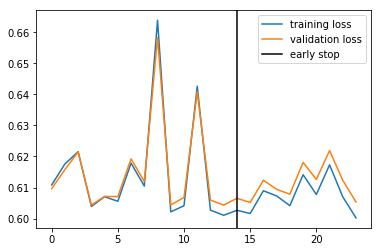

In [15]:
plt.plot(range(result['final_epoch']), result["tloss"], label='training loss')
plt.plot(range(result['final_epoch']), result["vloss"], label='validation loss')
plt.axvline(x=result['best_epoch'], label='early stop', color='black')
plt.legend()
plt.show()


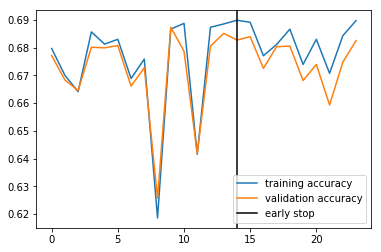

In [16]:
plt.plot(range(result['final_epoch']), result["taccs"], label='training accuracy')
plt.plot(range(result['final_epoch']), result["vaccs"], label='validation accuracy')
plt.axvline(x=result['best_epoch'], label='early stop', color='black')
plt.legend()
plt.show()

In [ ]:
net = Net(3, 32, 512)
net.train(X, y, result['best_epoch'], optimizer, criterion, batch_size, learning_rate)
y = []
split = 10
step = int(len(submission) / split)
for i in range(0, len(submission), step):
    batch = torch.Tensor(submission[i : i + step])
    batch = batch.view(-1, 3, 64, 64)
    batch = batch.cuda()

    y += list(map(int, net.forward(batch).max(1)[1].cpu()))

y = pd.DataFrame(y)
y.index.name = "id"
y.columns = ["label"]
y = y.replace(0, "Cat")
y = y.replace(1, "Dog")
y.index += 1
y.to_csv("submission.csv")